In [39]:
import sys
sys.path.append('../')
import numpy

from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu,\
    NewRewardUtils as nr \

from reward import AWSReward, RewardFactory
import reward.awsreward as rewards
from utils.loader import load_logs
from utils.transformer import df_to_params, calculate_iteration, new_names_df

tu = TrackIO(base_path='../tracks')
track = tu.load_track("reinvent_base")
fname = '../logs/training-simulation-logs-w7.log'

full_df = load_logs(fname)
calculate_iteration(full_df)

full_df['duration'] = full_df[['episode','numeric_timestamp']].groupby('episode').transform(lambda x: x - x.min())

In [93]:
rewards.RewardW6

In [96]:
class NewReward(rewards.RewardW7):
    
    def base_reward(self):
        return -1
    

In [97]:
factory = RewardFactory(rewards.RewardW7)
factory.rewards()

['RewardW8', 'NewReward']

In [98]:
def df_by_episode(full_df,episode_number):
    df = full_df.loc[full_df['episode']==episode_number,:].copy()
    df = df.sort_values('step')
    factory.calculate_new_reward(df, track.center_line,df_to_params,'NewReward',missing_params=None)
    cumulative_reward = df.loc[:,['iteration','episode','reward','NewReward']].groupby(['iteration','episode']).cumsum()
    cumulative_reward.columns = [f'cumulative_{x}' for x in cumulative_reward.columns]
    df = df.merge( cumulative_reward, left_index=True,right_index=True )
    return df

def plot_new_reward(df):
    new_df = df.loc[:,['cumulative_reward','duration','cumulative_NewReward','step']]
    new_df = new_df.set_index('duration').sort_index()
    new_df.plot()

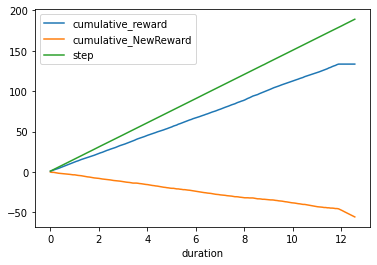

In [99]:
df = df_by_episode(full_df,1)
plot_new_reward(df)

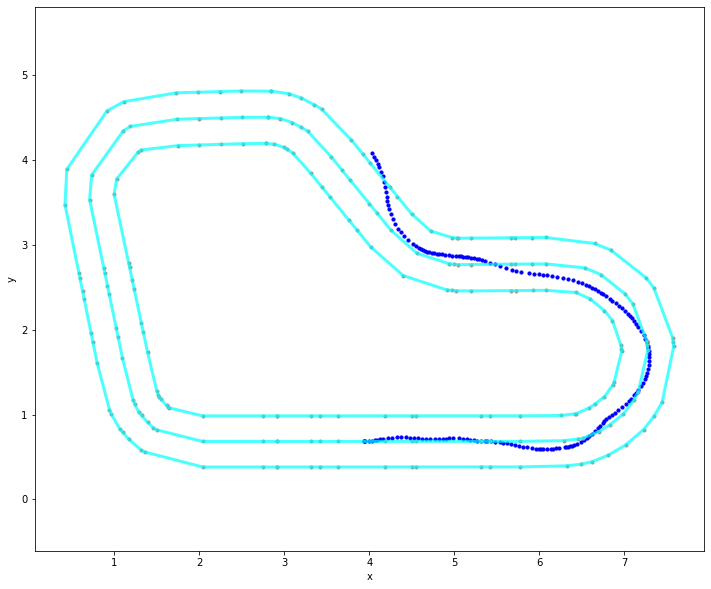

<Figure size 432x288 with 0 Axes>

In [74]:
pu.plot_selected_laps(df, new_names_df(df), track)

In [95]:
def summary(df):
    aggregation_map = {'step':numpy.max,
                       'closest_waypoint_index': lambda x: x.values[0],
                       'progress':numpy.max,
                       'speed':numpy.mean,
                       'time':numpy.ptp,
                       'reward': numpy.sum,
                       'NewReward': numpy.sum,
                       'duration':numpy.max,
                      }
    return df.groupby(['iteration','episode']).agg(aggregation_map)
summary(df)

,,step,closest_waypoint_index,progress,speed,time,reward,NewReward,duration
iteration,episode,,,,,,,,
1,1,189,4,48.9639,0.629365,00:00:12,133.469,-55.531,12.568453
